# *Simulated kernels for homogenious Poisson spiking process* 

# __I. Preparation for the main work__

### *First we need to import some useful python packages* 

In [1]:
import numpy as np
from numpy import pi, isnan, nanmin, nanmax
from scipy.special import erf
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import scipy.stats as stts

import pandas as pd
import matplotlib.pyplot as plt
import random
import math

np.random.seed(10)

### *Coping some functions from models.py* 

In [2]:
def wrapped_gaussian(x, pref_ori=0, rp=1, r0=0, sigma=30, period=180, n=None):
    """
    A smooth orientation tuning function constructed from gaussians shifted by the period.

    By using an infinite sum of gaussians with preferred orientations at phi, phi+period,
    phi+2*period, ... , one can create a smooth orientation tuning function. In practice a few
    gaussians are enough for most cases but if tuning widths become very large, a larger number
    of gaussians is needed to adequately represent the infinite sum. Taken from Swindale, 1998.

    Parameters
    ----------
    x : array-like
        orientations in degrees
    pref_ori : float between 0 and period
        preferred orientation
    rp : float
        response to the preferred orientation
    r0 : float
        background response
    sigma : float
        width parameter
    period : float
        circular period
    n : int
        number of gaussians in sum

    References
    ----------
    Swindale, N. V. (1998). Orientation tuning curves: Empirical description and estimation of
    parameters. Biological Cybernetics, 78(1), 45–56. https://doi.org/10.1007/s004220050411
    """
    def _wg(k):
        res = np.exp(-(x - pref_ori) ** 2 / (2 * sigma ** 2))
        for i in range(k):
            res += np.exp(-(x - pref_ori + period * (i + 1)) ** 2 / (2 * sigma ** 2))
            res += np.exp(-(x - pref_ori - period * (i + 1)) ** 2 / (2 * sigma ** 2))
        try:
            res = res/np.max(res)
        except FloatingPointError:
            pass
        return (rp-r0) * res + r0

    if n is None:
        n = 0
        while not np.allclose(_wg(n), _wg(n+1)) and n < 20:
            n += 1
    else:
        pass
    return _wg(n)



In [3]:
def hyper_ratio(x, Rmax, sigma, n, R0, s=1):
    """
    Hyperbolic ratio function (has sigmoidal shape). Mainly used to fit
    contrast responses.

    Hyperbolic ratio functions are part of the familiy of sigmoidal functions
    and can be formulated as:
        `y = Rmax * x^n / (sigma^(s*n)+x^(s*n)) + R0`
    This version has an optional parameter s that can be used to model super-
    saturation.

    Parameters
    ----------
    x : array-like
        independent variable of the function; usually contrast values
    Rmax : float
        maximum value of the function; usually maximal response of a unit
    R0 : float
        lowest value of the function; usually baseline response of a unit
    sigma : float
        x value for y halfway between Rmax and R0; usually contrast at 50%
        of maximum response (c50)
    n : float
        "slope" of the function
    s : float
        supersaturation parameter; bends the function back down after its
        maximum

    Returns
    -------
    y : array-like
        dependent variable of the function; usually firing response of a unit

    Examples
    --------
    >>> cons = np.linspace(0,1,10)
    >>> hyper_ratio(cons, 1, 0.5, 3, 0, 1)
    array([0. , 0.01085482, 0.08070618, 0.22857143, 0.41257051,
           0.578369, 0.7032967, 0.79009502, 0.84891192, 0.88888889])
    """
    numerator = x**n
    denominator = sigma**(s*n) + numerator**s
    if isnan(denominator).all():
        y = np.tile(np.inf, len(x))
    elif (denominator > 0).all():
        y = (Rmax - R0) * numerator / denominator + R0
    else:
        y = np.tile(np.inf, len(x))
    return y


# __II. The main work__

### *Plotting 3D tuning curves* 

In [4]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

## II.2 Simulating spiking process 

In [6]:
import plotly
import numpy as np
import chart_studio.plotly as py
import plotly.graph_objs as go

import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import stats
%matplotlib inline

plotly.offline.init_notebook_mode(connected=True)
from IPython.core.display import display, HTML, Markdown
# The polling here is to ensure that plotly.js has already been loaded before
# setting display alignment in order to avoid a race condition.
display(HTML(
    '<script>'
        'var waitForPlotly = setInterval( function() {'
            'if( typeof(window.Plotly) !== "undefined" ){'
                'MathJax.Hub.Config({ SVG: { font: "STIX-Web" }, displayAlign: "center" });'
                'MathJax.Hub.Queue(["setRenderer", MathJax.Hub, "SVG"]);'
                'clearInterval(waitForPlotly);'
            '}}, 250 );'
    '</script>'
))

# Colorscales
def colorscale_list(cmap, number_colors, return_rgb_only=False):
    cm = plt.get_cmap(cmap)
    colors = [np.array(cm(i/number_colors)) for i in range(1, number_colors+1)]
    rgb_colors_plotly = []
    rgb_colors_only = []
    for i, c in enumerate(colors):
        col = 'rgb{}'.format(tuple(255*c[:-1]))
        rgb_colors_only.append(col)
        rgb_colors_plotly.append([i/number_colors, col])
        rgb_colors_plotly.append([(i+1)/number_colors, col])
    return rgb_colors_only if return_rgb_only else rgb_colors_plotly

C:\Users\annak\AppData\Local\Temp\ipykernel_25056\3216130413.py:12: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [6]:
from collections import defaultdict
import statistics

### *Reconstructing 3D tuning curves* 

15000
len(stim) 15000
len(stim_phase) 15000
(18000, 100)
(18000, 100)


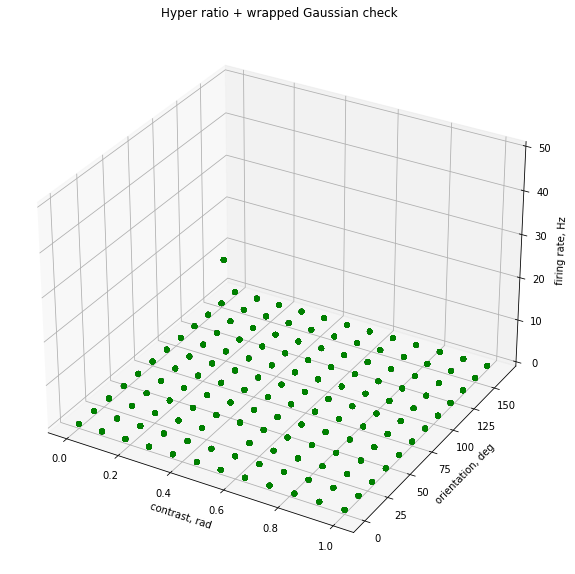

In [7]:
# Fixed firing rate (one stimulus has 10 Hz (10 spikes per T) 
#and other combinations have 0 Hz firing rate)

rates_val = [0, 40]
s = list(np.linspace(0, 1, 12)) #contrast
s = [round(num, 3) for num in s]
s2 = list(np.arange(0, 166, 15))
phase_unique = [0, 90, 180, 270]
spat_freq_unique = [0.0245471, 0.1, 0.40738]

N = 1
delta_t = 0.064 # in 1 ms can one spike occure
# t_max = 2999.9761
t_max = 960
times = np.arange(0, t_max, delta_t)
print(len(times))
s_array = np.array([random.sample(s, 1)[0] for i in times]) #contrast
s2_array = np.array([random.sample(s2, 1)[0] for i in times]) #orientation

spat_freq_array = np.array([random.sample(spat_freq_unique, 1)[0] for i in times])
phase_array = np.array([random.sample(phase_unique, 1)[0] for i in times])

stim = list(zip(s2_array, s_array))
print('len(stim)', len(stim))
stim_phase = list(zip(s2_array, s_array, spat_freq_array, phase_array))
print('len(stim_phase)', len(stim_phase))
def rate(t_max, delta_t):


    rates = []
    for i in stim:
        if i == (30, 0.455):
            rates.append(rates_val[1])
        else:
            rates.append(rates_val[0])
    
    list_s_r = list(zip(s_array, rates))
    list_s_r.sort(key=lambda x:x[0])
    list_s2_r = list(zip(s2_array, rates))
    list_s2_r.sort(key=lambda x:x[0])
    
    result = {}
    result2 = {}
# iterating over the tuples
    for sub_tuple in list_s_r:
        if sub_tuple[0] in result:
            result[sub_tuple[0]] = result[sub_tuple[0]] + [sub_tuple[1]]
        else:
            result[sub_tuple[0]] = [sub_tuple[1]]
    tuples = []
    for key,value in result.items():
#             print(len(value))
        tuples.append((key, sum(value) / len(value)))
#     print(tuples)

    for sub_tuple1 in list_s2_r:
        if sub_tuple1[0] in result2:
            result2[sub_tuple1[0]] = result2[sub_tuple1[0]] + [sub_tuple1[1]]
        else:
            result2[sub_tuple1[0]] = [sub_tuple1[1]]
    tuples2 = []
    for key,value in result2.items():
        tuples2.append((key, sum(value) / len(value)))
#     print(tuples2)
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(15,10))
    X = np.arange(0, 1, 0.01)
    Y = np.arange(0, 180, 0.01)
    X, Y = np.meshgrid(X, Y)
    print(np.shape(X))
    print(np.shape(Y))
    stim_R = list(zip(X, Y))

    ax.scatter3D(s_array, s2_array, rates, color = "green") #reconstructing tuning curve 3D
   




    # Creating plot
    plt.title("Hyper ratio + wrapped Gaussian check")
    ax.set_ylabel('orientation, deg')
    ax.set_xlabel('contrast, rad')
    ax.set_zlabel('firing rate, Hz')
    ax.set_zlim(0,50)
    
    # show plot
    plt.show()

#         plt.plot(s_array, rates,'o')
#         plt.show()
    return rates


rates = rate(t_max, delta_t)







In [8]:
### from scipy.interpolate import griddata
from scipy.interpolate import griddata
from sklearn import preprocessing

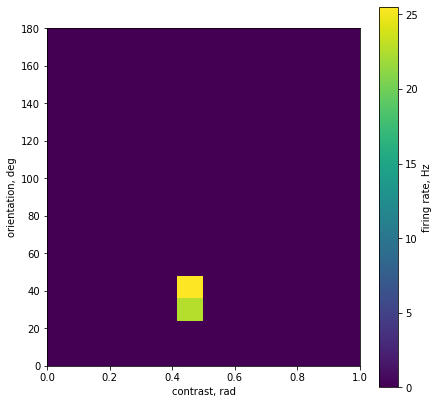

In [9]:
x = s_array
y = s2_array
rates_2d = []
rates_val = [0, 40]
for i in stim:
    if i == (30, 0.455):
        rates_2d.append(rates_val[1])
    else:
        rates_2d.append(rates_val[0])
grid_x,grid_y = np.meshgrid(np.linspace(0, 1, 12),np.linspace(0, 166-1, 15))
z = rates_2d


grid_z = griddata((x,y), z, (grid_x, grid_y), method='linear')


# x and y are bounds, so z should be the value *inside* those bounds.

# Therefore, remove the last value from the z array.


fig, ax = plt.subplots(figsize=(7,7))

p = ax.imshow(grid_z, origin='lower',extent=[0,1,0,180])
ax.set_aspect(0.006)
col = plt.colorbar(p)
col.set_label('firing rate, Hz')
ax.set_ylabel('orientation, deg')
ax.set_xlabel('contrast, rad')
plt.show()

In [10]:
def flatten(xss):
    return [x for xs in xss for x in xs]

# print(len(rates))
# ttt = np.arange(0, 2999.977, 0.001)
ttt = np.arange(0, 960, 0.001)
print(len(ttt))
# print(times)
timessss = []
for i in range(len(times)-1):
    per = np.arange(times[i],times[i+1]-0.001/2, 0.001)
    timessss.append(per)
#     print(per)
print(len(timessss))
print(len(timessss[0]))
print(len(timessss[100]))
print(len(flatten(timessss)))

rates_seq = []
for i in range(len(timessss)):
    rates_i = [rates[i] for x in range(len(timessss[i]))]
#     print(rates_i)
    rates_seq.append(rates_i)
    
stim_seq = []
for i in range(len(timessss)):
    stim_i = [stim[i] for x in range(len(timessss[i]))]
#     print(rates_i)
    stim_seq.append(stim_i)
stim_seq_all = flatten(stim_seq)
stim_seq_all = stim_seq_all
print('len(stim_seq_all)', len(stim_seq_all))

stim_seq_phase = []
for i in range(len(timessss)):
    stim_i_phase = [stim_phase[i] for x in range(len(timessss[i]))]
#     print(rates_i)
    stim_seq_phase.append(stim_i_phase)
stim_seq_all_phase = flatten(stim_seq_phase)
stim_seq_all_phase = stim_seq_all_phase
print('len(stim_seq_all_phase)', len(stim_seq_all_phase))

rates_seq_all = flatten(rates_seq)
rates_seq_all = rates_seq_all
print('len(rates_seq_all)', len(rates_seq_all))
timessss_all = flatten(timessss)
timessss_all = timessss_all
print('len(timessss_all)', len(timessss_all))

# print(timessss[-2])
# print(timessss[-1])

960000
14999
64
64
959936
len(stim_seq_all) 959936
len(stim_seq_all_phase) 959936
len(rates_seq_all) 959936
len(timessss_all) 959936


In [13]:
indices = [i for i, x in enumerate(stim) if x == (30, 0.455)]

In [17]:
delta_t_new = 0.001
times_new = timessss_all
# t_max = 2999.975
t_max = 960
# spikes = np.zeros((N, int(t_max/delta_t_new)))
spikes = []
for i in stim:
    if i == (30, 0.455):
        spikes.append(np.random.choice([0, 1], size=(64), p=[24/64, 40/64]))
    else:
        spikes.append(np.zeros(64))

spikes = flatten(spikes)
print((spikes[100]))
print(len(stim))
# print(spikes)
# spikes[np.random.rand(N,int(t_max/delta_t_new)) < np.array(rates_seq_all)*delta_t_new] = 1
# spikes_index =  []
spikes_index = []
for i in range(len(spikes)):
    if spikes[i] == 1.0:
        spikes_index.append(i)
        


print('spikes_index:', len(spikes_index))
spikes_times = [timessss_all[x] for x in spikes_index]
spikes_times = [i for i in spikes_times]
print('spikes_times:', len(spikes_times))
print('num_of_spikes:', len(spikes_times))
#     print(len(spikes[0]))
# print('firing rate_another_way = ',np.sum(spikes)/N)
print('len(timessss_all)',len(timessss_all))
# print((spikes))

0.0
15000
spikes_index: 4118
spikes_times: 4118
num_of_spikes: 4118
len(timessss_all) 959936


In [18]:
stim_spikes = [stim_seq_all[x] for x in spikes_index]
print('stim_spikes:', len(stim_spikes))
stim_spikes_phase = [stim_seq_all_phase[x] for x in spikes_index]
print('stim_spikes:', len(stim_spikes_phase))

stim_spikes: 4118
stim_spikes: 4118


In [20]:
from statistics import mean

In [21]:
from collections import defaultdict

def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return ((key,locs) for key,locs in tally.items() 
                            if len(locs)>1)

source = stim
source_phase = stim_phase
# source = stim_seq_all
list_d = []
list_d_phase = []
for dup in sorted(list_duplicates(source)):
    list_d.append(dup)
    
dupl = dict((x, y) for x, y in list_d)

for i in sorted(list_duplicates(source_phase)):
    list_d_phase.append(i)
    
dupl_phase = dict((x, y) for x, y in list_d_phase)
# print(dupl_phase)

In [23]:
import itertools

combinations = list(itertools.product(s2, s))
print(len(combinations))
combinations = sorted(combinations, key=lambda x: x[1])
stim_id_general = dict(zip(range(len(combinations)), combinations))
print(stim_id_general)

144
{0: (0, 0.0), 1: (15, 0.0), 2: (30, 0.0), 3: (45, 0.0), 4: (60, 0.0), 5: (75, 0.0), 6: (90, 0.0), 7: (105, 0.0), 8: (120, 0.0), 9: (135, 0.0), 10: (150, 0.0), 11: (165, 0.0), 12: (0, 0.091), 13: (15, 0.091), 14: (30, 0.091), 15: (45, 0.091), 16: (60, 0.091), 17: (75, 0.091), 18: (90, 0.091), 19: (105, 0.091), 20: (120, 0.091), 21: (135, 0.091), 22: (150, 0.091), 23: (165, 0.091), 24: (0, 0.182), 25: (15, 0.182), 26: (30, 0.182), 27: (45, 0.182), 28: (60, 0.182), 29: (75, 0.182), 30: (90, 0.182), 31: (105, 0.182), 32: (120, 0.182), 33: (135, 0.182), 34: (150, 0.182), 35: (165, 0.182), 36: (0, 0.273), 37: (15, 0.273), 38: (30, 0.273), 39: (45, 0.273), 40: (60, 0.273), 41: (75, 0.273), 42: (90, 0.273), 43: (105, 0.273), 44: (120, 0.273), 45: (135, 0.273), 46: (150, 0.273), 47: (165, 0.273), 48: (0, 0.364), 49: (15, 0.364), 50: (30, 0.364), 51: (45, 0.364), 52: (60, 0.364), 53: (75, 0.364), 54: (90, 0.364), 55: (105, 0.364), 56: (120, 0.364), 57: (135, 0.364), 58: (150, 0.364), 59: (16

In [25]:
orient = []
for i in combinations:
    orient.append(i[0])
print(len(orient))

contr = []
for i in combinations:
    contr.append(i[1])
print((contr))

144
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.182, 0.182, 0.182, 0.182, 0.182, 0.182, 0.182, 0.182, 0.182, 0.182, 0.182, 0.182, 0.273, 0.273, 0.273, 0.273, 0.273, 0.273, 0.273, 0.273, 0.273, 0.273, 0.273, 0.273, 0.364, 0.364, 0.364, 0.364, 0.364, 0.364, 0.364, 0.364, 0.364, 0.364, 0.364, 0.364, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.545, 0.545, 0.545, 0.545, 0.545, 0.545, 0.545, 0.545, 0.545, 0.545, 0.545, 0.545, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.727, 0.727, 0.727, 0.727, 0.727, 0.727, 0.727, 0.727, 0.727, 0.727, 0.727, 0.727, 0.818, 0.818, 0.818, 0.818, 0.818, 0.818, 0.818, 0.818, 0.818, 0.818, 0.818, 0.818, 0.909, 0.909, 0.909, 0.909, 0.909, 0.909, 0.909, 0.909, 0.909, 0.909, 0.909, 0.909, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [27]:
spat_freq_comb = np.array([random.sample(spat_freq_unique, 1)[0] for i in orient])
phase_comb = np.array([random.sample(phase_unique, 1)[0] for i in orient])
print(len(spat_freq_comb))

144


In [28]:
def get_key(val):
    for key, value in stim_id_general.items():
         if val == value:
             return key
 
    return "There is no such Key"

In [29]:
stim_id_key = list(stim_id_general.keys())
print(stim_id_key)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]


In [30]:
grat_cond = []
grat_cond.append(np.array(stim_id_key))
grat_cond.append(np.array(orient))
grat_cond.append(np.array(contr))
grat_cond.append(np.array(spat_freq_comb))
grat_cond.append(np.array(phase_comb))
# print((grat_cond))
for i in grat_cond:
    print(i[62])

62
30
0.455
0.1
0


In [31]:
stim_id_spikes = []
for i in stim_spikes:
    stim_id_spikes.append(get_key(i))

In [33]:
# counting spikes for each stimulus (should be 0 for all except the prefered stimulus)
res1 = {}
for i in range(144):
    res1[i] = stim_id_spikes.count(i)
    
print(res1)

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 4118, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 13

In [34]:
# counting number of intervals (from stim) where spikes occurres (prefered stimulus)
# two types of calculations to check if the simulation works well 
# if equal => well done!
stim_id = []
for i in stim:
    stim_id.append(get_key(i))
# print(len(stim_id))
stim_id = stim_id[:-1]
# print((stim_id))
# print(stim)
# print(list(zip(stim_id, stim)))
#first way
preff_stim = []
for i in list(zip(stim_id, stim)):
    if i == (62, (30, 0.455)):
        preff_stim.append(i)
print(len(preff_stim))

# second way
stim_preff = []
for i in stim:
    if i == (30, 0.455):
        stim_preff.append(i)
print(len(stim_preff))

if len(preff_stim) == len(stim_preff):
    print('Well done!')
else:
    print('Check again!')

103
103
Well done!


In [35]:
# counting number of stim intervals for each stimulus in simulated time interval
res2 = {}
for i in range(144):
    res2[i] = stim_id.count(i)

print((res2))
# print((res2.values()))
print()
if len(preff_stim) == res2[62]:
    print('Well done!')
else:
    print('Check again!')

{0: 105, 1: 99, 2: 103, 3: 92, 4: 111, 5: 112, 6: 98, 7: 84, 8: 104, 9: 91, 10: 108, 11: 88, 12: 100, 13: 104, 14: 96, 15: 90, 16: 107, 17: 99, 18: 102, 19: 94, 20: 98, 21: 83, 22: 99, 23: 120, 24: 104, 25: 103, 26: 109, 27: 107, 28: 108, 29: 104, 30: 111, 31: 88, 32: 102, 33: 105, 34: 111, 35: 91, 36: 95, 37: 110, 38: 102, 39: 125, 40: 112, 41: 128, 42: 110, 43: 97, 44: 99, 45: 108, 46: 106, 47: 98, 48: 110, 49: 100, 50: 124, 51: 108, 52: 111, 53: 113, 54: 110, 55: 108, 56: 115, 57: 112, 58: 113, 59: 109, 60: 98, 61: 102, 62: 103, 63: 108, 64: 80, 65: 107, 66: 107, 67: 99, 68: 90, 69: 84, 70: 102, 71: 111, 72: 106, 73: 108, 74: 114, 75: 88, 76: 119, 77: 111, 78: 103, 79: 109, 80: 113, 81: 101, 82: 119, 83: 98, 84: 89, 85: 90, 86: 79, 87: 118, 88: 104, 89: 108, 90: 105, 91: 105, 92: 113, 93: 103, 94: 126, 95: 111, 96: 98, 97: 113, 98: 116, 99: 107, 100: 90, 101: 81, 102: 112, 103: 100, 104: 121, 105: 100, 106: 102, 107: 104, 108: 106, 109: 118, 110: 93, 111: 99, 112: 90, 113: 87, 114: 

In [36]:
firing_rates_av = {k: round(res1[k]/(res2[k]), 2) for k in res1}
firing_rates_av_list = sorted(firing_rates_av.items())
print((firing_rates_av_list))

[(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0), (10, 0.0), (11, 0.0), (12, 0.0), (13, 0.0), (14, 0.0), (15, 0.0), (16, 0.0), (17, 0.0), (18, 0.0), (19, 0.0), (20, 0.0), (21, 0.0), (22, 0.0), (23, 0.0), (24, 0.0), (25, 0.0), (26, 0.0), (27, 0.0), (28, 0.0), (29, 0.0), (30, 0.0), (31, 0.0), (32, 0.0), (33, 0.0), (34, 0.0), (35, 0.0), (36, 0.0), (37, 0.0), (38, 0.0), (39, 0.0), (40, 0.0), (41, 0.0), (42, 0.0), (43, 0.0), (44, 0.0), (45, 0.0), (46, 0.0), (47, 0.0), (48, 0.0), (49, 0.0), (50, 0.0), (51, 0.0), (52, 0.0), (53, 0.0), (54, 0.0), (55, 0.0), (56, 0.0), (57, 0.0), (58, 0.0), (59, 0.0), (60, 0.0), (61, 0.0), (62, 39.98), (63, 0.0), (64, 0.0), (65, 0.0), (66, 0.0), (67, 0.0), (68, 0.0), (69, 0.0), (70, 0.0), (71, 0.0), (72, 0.0), (73, 0.0), (74, 0.0), (75, 0.0), (76, 0.0), (77, 0.0), (78, 0.0), (79, 0.0), (80, 0.0), (81, 0.0), (82, 0.0), (83, 0.0), (84, 0.0), (85, 0.0), (86, 0.0), (87, 0.0), (88, 0.0), (89, 0.0), (90, 0.0), (91, 0

In [37]:
a = list(stim_id_general.values())
orient_fr = []
for i in a:
    orient_fr.append(i[0])
contr_fr = []
for i in a:
    contr_fr.append(i[1])

In [38]:
x, fr_av = zip(*firing_rates_av_list)
fr_av = list(fr_av)
print(mean(fr_av))

0.2776388888888889


In [39]:
trials_on_time = times[:-1]
trials_off_time = times[1:]
trials_on_time = [i+0.001 for i in trials_on_time]
trials_off_time = [i for i in trials_off_time]
trials_id = [trials_on_time.index(i) for i in trials_on_time]
print(len(trials_on_time))
print(len(trials_id))
print(len(trials_off_time))

14999
14999
14999


In [40]:
trials = pd.DataFrame({'stim_id': stim_id, 'trial_id': trials_id,
                               'trial_on_time': trials_on_time,
                               'trial_off_time': trials_off_time})

In [41]:
# To check if trials organized in a right order
stim_keyss = []
for i in stim:
    stim_keyss.append(get_key(i))
print(stim_keyss)

[10, 114, 59, 95, 92, 62, 117, 122, 140, 50, 109, 51, 126, 24, 93, 34, 23, 96, 34, 1, 88, 59, 10, 39, 77, 27, 20, 56, 118, 142, 71, 38, 111, 42, 52, 15, 71, 11, 86, 29, 106, 33, 6, 34, 6, 66, 102, 99, 18, 107, 38, 19, 42, 67, 117, 30, 49, 141, 71, 70, 94, 68, 38, 71, 10, 98, 53, 82, 88, 141, 119, 105, 67, 1, 138, 74, 71, 129, 2, 25, 92, 67, 105, 130, 54, 37, 17, 100, 136, 51, 24, 7, 53, 5, 131, 53, 4, 61, 83, 62, 65, 124, 87, 116, 91, 8, 56, 130, 22, 116, 91, 40, 109, 23, 99, 55, 18, 120, 47, 122, 61, 100, 40, 57, 25, 124, 81, 24, 125, 140, 71, 8, 30, 74, 143, 60, 94, 115, 107, 140, 94, 30, 131, 21, 141, 45, 73, 74, 39, 41, 12, 54, 102, 18, 104, 88, 54, 35, 53, 5, 80, 75, 137, 59, 64, 83, 10, 132, 41, 110, 0, 27, 52, 80, 79, 43, 77, 60, 3, 102, 55, 94, 102, 2, 13, 80, 29, 137, 137, 46, 53, 86, 30, 105, 12, 105, 134, 35, 122, 96, 60, 90, 130, 133, 101, 61, 20, 18, 103, 28, 46, 56, 58, 125, 96, 105, 4, 50, 24, 89, 120, 28, 52, 37, 70, 4, 6, 131, 51, 74, 124, 78, 37, 89, 141, 71, 59, 96, 

In [42]:
trials

,stim_id,trial_id,trial_on_time,trial_off_time
0,10,0,0.001,0.064
1,114,1,0.065,0.128
2,59,2,0.129,0.192
3,95,3,0.193,0.256
4,92,4,0.257,0.320
...,...,...,...,...
14994,46,14994,959.617,959.680
14995,15,14995,959.681,959.744
14996,114,14996,959.745,959.808
14997,130,14997,959.809,959.872


# __III. Plotting kernels__

In [43]:
import os
import re
import sys
import datetime
from datetime import date
from socket import getfqdn

import pkg_resources # installed by setuptools package
from distutils.version import LooseVersion
from scipy.io import loadmat
import scipy
import scipy.stats as stts
from types import new_class
import textwrap




from pdb import set_trace as db # AKA, debug - shortcut for dropping into debugge

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datajoint as dj
import seaborn as sns
from statsmodels.sandbox.stats.runs import runstest_1samp
from scipy.signal import find_peaks



In [45]:
# not changed 
def get_t_kernels(spike_times, trials, dtrange, precision, bin_spikes=True):
    """Collects temporal reverse correlation kernels.

    Computes the posterior probability that a stimulus elicits a spike in a
    time bin specified by precision at temporal delay delta_t for all delta_t
    in dtrange.

    Parameters
    ----------
    spike_times : np.array
        spike times
    trials : pd.DataFrame
        keys: "stim_id", "trial_on_time", "trial_off_time"
        compound representation of stimulus trials
    dtrange : np.array
        time delays at which to compute the reverse correlation
    precision : int
        decimal precision at which to bin and threshold spikes and trials
    bin_spikes : boolean
        if set to false, spikes will not be binned before kernel calculation.
        This is designed for use in resampling analyses. Setting it to False
        can result in incorrec probability values.

    Returns
    -------
    kernels : pd.DataFrame
        keys "stim_id", "delta_t", "P(Spike|Stim)"
        compound representation of spiking probability for each stimulus and
        delta_t from dtrange

    Examples
    --------
    >>> trials = pd.DataFrame({'stim_id': [0, 1, 0, 1, 0],
                               'trial_on_time': [0, 0.1, 0.2, 0.3, 0.4],
                               'trial_off_time': [0.1, 0.2, 0.3, 0.4, 0.5]})
    >>> spk_times = np.array([0.15, 0.151, 0.35, 0.45])
    >>> precision = 3
    >>> dts = np.array([-0.1, 0, 0.1])
    >>> get_t_kernels(spk_times, trials, dts, precision)
    pd.DataFrame({'stim_id': [0, 0, 0, 1, 1, 1],
                  'delta_t': [-0.1, 0, 0.1, -0.1, 0, 0.1],
                  'p_spike_stim': [3/300, 1/300, 3/300, 0/200, 3/200, 1/200]})

    References
    ----------
    Ringach, D., & Shapley, R. (2004). Reverse correlation in neurophysiology.
    Cognitive Science, 28(2), 147–166.
    https://doi.org/10.1016/j.cogsci.2003.11.003
    """
    spike_times = spikes_times
    probs = pd.DataFrame()
    for dt in dtrange:
        Pdt = get_P_spike_given_stim(spike_times, trials, precision, dt,
                                     bin_spikes)
        probs = probs.append(Pdt, ignore_index=True)
    probs = probs.sort_values('stim_id').reset_index(drop=True)
    return probs


In [46]:
# not changed 
def get_P_spike_given_stim(spike_times, trials, precision, delta_t=0,
                           bin_spikes=True):
    """Calculate the posterior probability for a stimulus to elicit a spike at
    time delay delta_t (also termed reverse correlation).

    Applies Bayes' formula to spike data. The full formula is:
        P(Spike|Stim) = (P(Stim|Spike) * P(Spike)) / P(Stim)
    Which translates to:
        P(Spike|Stim) = (stim_spikes/nspikes * nspikes/nbins) /
        stimbins/nbins
    This reduces to:
        P(Spike|Stim) = stim_spikes/stimbins
    Which is what the function implements by:
        - binning and thresholding spikes at chosen precision
        - shifting spike times by delta_t
        - counting how many spike times fall into each trial
        - summing the spike counts for each stimulus (stim_spikes)
        - counting total presentation time for each stimulus in bins (stimbins)
        - dividing stim_spikes by stimbins

    Parameters
    ----------
    spike_times : np.ndarray
        spike times
    trials : pd.DataFrame
        keys: "stim_id", "trial_on_time", "trial_off_time"
        compound representation of stimulus trials
    precision : int
        decimal precision at which to bin and threshold spikes and trials
    delta_t : float
        time delay at which to compute the reverse correlation
    bin_spikes : boolean, default True
        if set to false, spikes will not be binned before kernel calculation.
        This is designed for use in resampling analyses. Setting it to False
        can result in incorrec probability values.

    Returns
    -------
    nstimspks : pd.DataFrame
        keys "stim_id", "delta_t", "P(Spike|Stim)"
        compound representation of spiking probability for each stimulus and
        the chosen delta_t

    Examples
    --------
    >>> trials = pd.DataFrame({'stim_id': [0, 1],
                               'trial_on_time': [0.0, 0.1],
                               'trial_off_time': [0.1, 0.2]})
    >>> spk_times = np.array([0.15, 0.151])
    >>> precision = 3
    >>> get_P_spike_given_stim(spk_times, trials, precision)
    pd.DataFrame({'stim_id': [0, 1],
                  'delta_t': [0, 0],
                  'p_spike_stim': [0.0, 0.02]})

    Switching off binning mode:
    >>> precision = 2
    >>> get_P_spike_given_stim(spk_times, trials, precision)
    pd.DataFrame({'stim_id': [0, 1],
                  'delta_t': [0, 0],
                  'p_spike_stim': [0.0, 0.01]})

    >>> precision = 2
    >>> get_P_spike_given_stim(spk_times, trials, precision, bin_spikes=False)
    pd.DataFrame({'stim_id': [0, 1],
                  'delta_t': [0, 0],
                  'p_spike_stim': [0.0, 0.02]})
    """
    spike_times = spikes_times
    if bin_spikes:
        spike_times = binarize_events(spike_times, precision)
    else:
        pass
    stim_ids, spk_counts = count_stim_spikes(spike_times,
                                             trials['trial_on_time'].values,
                                             trials['trial_off_time'].values,
                                             trials['stim_id'].values,
                                             delta_t)
    nstimspks = pd.DataFrame({'stim_id': stim_ids,
                              'delta_t': np.repeat(delta_t, len(stim_ids)),
                              'p_spike_stim': spk_counts})
    nstimbins = count_stim_bins(trials['stim_id'].values,
                                trials['trial_on_time'].values,
                                trials['trial_off_time'].values,
                                precision)
    nstimspks['p_spike_stim'] = nstimspks['p_spike_stim']/nstimbins['bins']
    return nstimspks


In [47]:
# not changed 
def binarize_events(event_times, precision):
    """Bin event times at the specified precision level (number of decimals).

    Rounds event times to specified precision level and then keeps only unique
    event times (equivalent to one event per bin).

    Parameters
    ----------
    event_times : array_like
        event times
    precision : int
        number of decimals
        

    Returns
    -------
    res : ndarray
        array of binned event times

    Examples
    --------
    >>> evnt_times = np.array([1.21, 1.22, 2.5])
    >>> binarize_events(evnt_times, 1)
    array([1.2, 2.5])

    >>> evnt_times = np.array([1.215, 1.223, 2.5])
    >>> binarize_events(evnt_times, 2)
    array([1.22, 2.5])
    """
    correct_input_type = type(precision) == int or type(precision) == np.int64
    if not correct_input_type:
        raise ValueError('arg "precision" dtype is supposed to be float.')
    int_evnt_times = np.round(event_times*10**precision).astype(int)
    return np.unique(int_evnt_times)/10**precision


In [48]:
# not changed 
def count_stim_spikes(spk_times, trial_on_times, trial_off_times, stim_ids, delta_t=0):
    """Count how many times a particular stimulus was displayed delta_t before
    a spike occurred.

    Parameters
    ----------
    spk_times : np.ndarray
        Time points at which a spike occured.
    trial_on_times : np.ndarray
        Trial start times
    trial_off_times : np.ndarray
        Trial stop times
    delta_t : float, optional
        Investigated difference between spike and stimulus presentation.

    Returns
    -------
    overall_stims : np.ndarray
        Unique stimulus ID that occurred in the trials.
    counts_spiking_stims : np.ndarray
        Number of spikes occurring delta_t after the stimulus presentation

    Notes
    -----
    All times have to be entered in the same format (e.g. milliseconds)

    Examples
    --------
    >>> trial_on_times = np.array([0, 0.21])
    >>> trial_off_times = np.array([0.1, 0.3])
    >>> stim_ids = np.array([1, 3])
    >>> spikes = np.array([0.01, 0.25, 0.29])
    >>> count_stim_spikes(spikes, trial_on_times, trial_off_times, stim_ids)
    ([1, 3], [1, 2])
    """
    spk_times = spikes_times
    spk_times = spk_times - delta_t
    # make sure trials are in ascending temporal order
    order = np.argsort(trial_on_times)
    trial_on_times = trial_on_times[order]
    trial_off_times = trial_off_times[order]
    stim_ids = stim_ids[order]
    # extract stimulus counts
    trial_indices = event_in_interval(spk_times, trial_on_times,
                                      trial_off_times)
    stimuli_preceeding_spikes = stim_ids[trial_indices]
    overall_stims = np.unique(stim_ids)
    uniques = np.unique(stimuli_preceeding_spikes, return_counts=True)
    (spiking_stims, tmp_counts_spiking_stims) = uniques
    # add zeros for stimuli that did not elicit any spikes
    spiking_stims_idcs = np.searchsorted(overall_stims, spiking_stims)
    counts_spiking_stims = np.zeros(len(overall_stims)).astype(int)
    counts_spiking_stims[spiking_stims_idcs] = tmp_counts_spiking_stims
    return overall_stims, counts_spiking_stims

In [49]:
# not changed 
def one_event_in_interval(on_off, event_t):
    """on_off: list of intervals
    lower border <eventtime <= upperborder
    """
    on, off = on_off.T
    evnt_position_on = np.searchsorted(on, event_t)
    evnt_position_off = np.searchsorted(off, event_t)
    # if event falls within interval, the on index must be larger than the
    # corresponding off index. The off index then gives the proper stimulus id
    evnt_in_interval = (evnt_position_on != evnt_position_off)
    return evnt_in_interval

In [50]:
# not changed 
def event_in_interval(event_times, interval_on_times, interval_off_times, precision=6,
                      return_event_times=False):
    """Check if events occured during each intervall and returns the indices of
    intervals with events.

    Parameters
    ----------
    event_times : array_like
        Time points at which events occured.
    interval_on_times : array_like
        Time points at which intervals started.
    interval_off_times : array_like
        Time points at which intervals ended.
    precision : int
        Decimal precision that will be used. Its purpose is  to avoid ambiguity
        due to float precision math.
    return_event_times : bool
        Flag to return the event times corresponding to the intervals

    Returns
    -------
    res : np.ndarray
        Indices of intervals where spikes occurred. If one interval had
        multiple spikes, its index will be listed multiple times.

    Examples
    --------
    >>> event_times = [0.5]
    >>> interval_on_times = [0]
    >>> interval_off_times = [1]
    >>> event_in_interval(event_times, interval_on_times, interval_off_times)
    array([0])

    >>> event_times = [0.5, 0.6]
    >>> interval_on_times = [0]
    >>> interval_off_times = [1]
    >>> event_in_interval(event_times, interval_on_times, interval_off_times)
    array([0, 0])

    >>> event_times = [0.5, 0.6, 1.2]
    >>> interval_on_times = [0, 1]
    >>> interval_off_times = [1, 2]
    >>> event_in_interval(event_times, interval_on_times, interval_off_times)
    array([0, 0, 1])
    """
    assert type(event_times) in (list, np.ndarray, pd.Series)
    assert type(interval_on_times) in (list, np.ndarray, pd.Series)
    assert type(interval_off_times) in (list, np.ndarray, pd.Series)
    assert type(precision) == int
    # rounding values to prevent float comparison errors
    interval_on_times = np.round(interval_on_times, precision)
    interval_off_times = np.round(interval_off_times, precision)
    event_times = np.round(event_times, precision)
    evnt_position_on = np.searchsorted(interval_on_times, event_times)
    evnt_position_off = np.searchsorted(interval_off_times, event_times)
    # if spike falls within interval, the on index must be larger than the
    # corresponding off index. The off index then gives the proper stimulus id
    evnt_in_interval = evnt_position_on != evnt_position_off
    if not return_event_times:
        return evnt_position_off[evnt_in_interval]
    else:
        return evnt_position_off[evnt_in_interval], event_times[evnt_in_interval]

In [51]:
# not changed 
def count_stim_bins(stim_ids, trial_on_times, trial_off_times, precision):
    """Discretises cumulative stimulus presentation time by counting the number of
    stimulus presentation bins.

    Parameters
    ----------
    stim_ids : np.ndarray
    trial_on_times : np.ndarray
    trial_off_times : np.ndarray
    precision : int

    Returns
    -------
    stimbins : pd.DataFrame with keys "stim_id" and "bins"

    Examples
    --------
    >>> stim_ids = np.array([0, 1, 1])
    >>> trial_on_times = np.array([0.01, 0.03, 0.05])
    >>> trial_off_times = np.array([0.02, 0.04, 0.06])
    >>> precision = 3
    >>> count_stim_bins(stim_ids, trial_on_times, trial_off_times, precision)
    pd.DataFrame({'stim_id': [0, 1],
                  'bins': [10, 20]})
    """
    stimbins = pd.DataFrame({'stim_id': stim_ids})
    stimbins['bins'] = (trial_off_times-trial_on_times) * 10**precision
    stimbins = stimbins.groupby('stim_id').sum().reset_index()
    stimbins = stimbins.round({'bins': 0})
    stimbins = stimbins.astype({'bins': int})
    return stimbins

def get_P_spike_given_stim(spike_times, trials, precision, delta_t=0,
                           bin_spikes=True):
    """Calculate the posterior probability for a stimulus to elicit a spike at
    time delay delta_t (also termed reverse correlation).

    Applies Bayes' formula to spike data. The full formula is:
        P(Spike|Stim) = (P(Stim|Spike) * P(Spike)) / P(Stim)
    Which translates to:
        P(Spike|Stim) = (stim_spikes/nspikes * nspikes/nbins) /
        stimbins/nbins
    This reduces to:
        P(Spike|Stim) = stim_spikes/stimbins
    Which is what the function implements by:
        - binning and thresholding spikes at chosen precision
        - shifting spike times by delta_t
        - counting how many spike times fall into each trial
        - summing the spike counts for each stimulus (stim_spikes)
        - counting total presentation time for each stimulus in bins (stimbins)
        - dividing stim_spikes by stimbins

    Parameters
    ----------
    spike_times : np.ndarray
        spike times
    trials : pd.DataFrame
        keys: "stim_id", "trial_on_time", "trial_off_time"
        compound representation of stimulus trials
    precision : int
        decimal precision at which to bin and threshold spikes and trials
    delta_t : float
        time delay at which to compute the reverse correlation
    bin_spikes : boolean, default True
        if set to false, spikes will not be binned before kernel calculation.
        This is designed for use in resampling analyses. Setting it to False
        can result in incorrec probability values.

    Returns
    -------
    nstimspks : pd.DataFrame
        keys "stim_id", "delta_t", "P(Spike|Stim)"
        compound representation of spiking probability for each stimulus and
        the chosen delta_t

    Examples
    --------
    >>> trials = pd.DataFrame({'stim_id': [0, 1],
                               'trial_on_time': [0.0, 0.1],
                               'trial_off_time': [0.1, 0.2]})
    >>> spk_times = np.array([0.15, 0.151])
    >>> precision = 3
    >>> get_P_spike_given_stim(spk_times, trials, precision)
    pd.DataFrame({'stim_id': [0, 1],
                  'delta_t': [0, 0],
                  'p_spike_stim': [0.0, 0.02]})

    Switching off binning mode:
    >>> precision = 2
    >>> get_P_spike_given_stim(spk_times, trials, precision)
    pd.DataFrame({'stim_id': [0, 1],
                  'delta_t': [0, 0],
                  'p_spike_stim': [0.0, 0.01]})

    >>> precision = 2
    >>> get_P_spike_given_stim(spk_times, trials, precision, bin_spikes=False)
    pd.DataFrame({'stim_id': [0, 1],
                  'delta_t': [0, 0],
                  'p_spike_stim': [0.0, 0.02]})
    """
    spike_times = spikes_times
    if bin_spikes:
        spike_times = binarize_events(spike_times, precision)
    else:
        pass
    stim_ids, spk_counts = count_stim_spikes(spike_times,
                                             trials['trial_on_time'].values,
                                             trials['trial_off_time'].values,
                                             trials['stim_id'].values,
                                             delta_t)
    nstimspks = pd.DataFrame({'stim_id': stim_ids,
                              'delta_t': np.repeat(delta_t, len(stim_ids)),
                              'p_spike_stim': spk_counts})
    nstimbins = count_stim_bins(trials['stim_id'].values,
                                trials['trial_on_time'].values,
                                trials['trial_off_time'].values,
                                precision)
    nstimspks['p_spike_stim'] = nstimspks['p_spike_stim']/nstimbins['bins']
    return nstimspks


In [52]:
nspikes = len(event_in_interval(spikes_times, trials['trial_on_time'], trials['trial_off_time']))
stim_dur = (trials['trial_off_time']-trials['trial_on_time']).sum()
meanrate = nspikes/stim_dur
print('meanrate = ', meanrate)

meanrate =  4.289174833876694


In [53]:
# not changed 
def convert_kernels(kernels):
    t_kernels = pd.DataFrame()
    for gname, group in kernels.groupby('stim_id'):
        piv_group = group.pivot_table('p_spike_stim', 'stim_id', 'delta_t')
   
        kernel = piv_group.apply(np.array, axis=1).reset_index()
#         print(t_kernel)
        t_kernels = t_kernels.append(kernel, ignore_index=True)
    t_kernels.rename(columns={0: 't_kernel'}, inplace=True)
    return t_kernels

In [54]:
# not changed 
def z_score_kernels(kernels):
    """Z score revcorr kernel dataframe across first 4 time points."""
    kernmat = np.stack(kernels['t_kernel'].values)
    z_scores = (kernmat - np.mean(kernmat[:, 0:4]))/np.std(kernmat[:, 0:4])
    z_kernels = kernels.drop(columns='t_kernel')
    z_kernels['z_kernel'] = [*z_scores]

    return z_kernels

In [55]:
trials = pd.DataFrame({'stim_id': stim_id, 'trial_id': trials_id,
                               'trial_on_time': trials_on_time,
                               'trial_off_time': trials_off_time})
# trials.sort_values(['stim_id',  'trial_id'], inplace=True)
trials

,stim_id,trial_id,trial_on_time,trial_off_time
0,10,0,0.001,0.064
1,114,1,0.065,0.128
2,59,2,0.129,0.192
3,95,3,0.193,0.256
4,92,4,0.257,0.320
...,...,...,...,...
14994,46,14994,959.617,959.680
14995,15,14995,959.681,959.744
14996,114,14996,959.745,959.808
14997,130,14997,959.809,959.872


In [56]:
key =  {'m': 'Simulated', 's':0, 'e': 0, 'u':0}

In [57]:
# Changed!!!
def make(self):
    

        precision = 3
        dtrange = np.arange(-0.15, 0.3, 0.01)
        trials = pd.DataFrame({'stim_id': stim_id, 'trial_id': trials_id,
                               'trial_on_time': trials_on_time,
                               'trial_off_time': trials_off_time})
        kernels = get_t_kernels(spikes_times, trials, dtrange, precision)
        kernels.set_index(['stim_id', 'delta_t'], inplace=True)
        trials.sort_values('trial_id', inplace=True)

        nspikes = len(event_in_interval(spikes_times, trials['trial_on_time'], trials['trial_off_time']))
        stim_dur = (trials['trial_off_time']-trials['trial_on_time']).sum()
        meanrate = nspikes/stim_dur
        paramset = 1
        t_kernels = convert_kernels(kernels.reset_index('stim_id'))
        z_kernels = z_score_kernels(t_kernels).set_index('stim_id')
        kernels_1 = t_kernels.join(z_kernels, on='stim_id')
        # add smoothed kernels with sliding window
        winlen = int(0.05/0.01)
        winarr = np.ones(winlen)
        def smooth(x): return np.correlate(x, winarr)/winlen
        

        # adding one column to dataframe and aplly smooth method for t_kernel column 
        kernels_1['s_kernel'] = t_kernels['t_kernel'].apply(smooth)
        kernels_2 = pd.DataFrame(data=key
                                 ,index=[0])
        new_column_values = kernels_1['stim_id']
        kernels_2["stim_id"] = new_column_values
        kernels = pd.concat([kernels_2, kernels_1])

        # creating the MultiIndexes        
        kernels['m'] = 'Simulated'
        kernels.set_index('m', append=True, inplace=True) 
        kernels['s'] = 0
        kernels.set_index('s', append=True, inplace=True) 
        kernels['e'] = 0
        kernels.set_index('e', append=True, inplace=True) 
        kernels['u'] = 0
        kernels.set_index('u', append=True, inplace=True)
        kernels['stim_id'] = kernels['stim_id']
        kernels.set_index('stim_id', append=True, inplace=True)
        kernels = kernels.iloc[1: , :]
        kernels = kernels.droplevel(level = 0)
        return kernels

In [58]:
dtrange = np.arange(-0.01, 0.03, 0.001)
precision = 1
# pd.set_option('display.max_rows', None)
df = ((get_t_kernels(spikes_times, trials, dtrange, precision)))
get_rows = df.head(100)
(df)

,stim_id,delta_t,p_spike_stim
0,0,-0.010,0.000000
1,0,0.004,0.000000
2,0,-0.006,0.000000
3,0,0.017,0.000000
4,0,0.025,0.000000
...,...,...,...
5755,143,0.013,0.283582
5756,143,0.012,0.268657
5757,143,0.011,0.238806
5758,143,0.018,0.358209


In [59]:
df_2 = df.groupby(['stim_id'])['p_spike_stim'].mean()
get_rows_2 = df_2.head(100) 
get_rows_2

stim_id
0     0.000000
1     0.087903
2     0.123077
3     0.133621
4     0.007500
        ...   
95    0.080357
96    0.142742
97    0.000000
98    0.391096
99    0.000000
Name: p_spike_stim, Length: 100, dtype: float64

In [60]:
GratingCond = pd.DataFrame({'stim_id': stim_id_key, 'orient': orient,
                               'contr': contr})

In [61]:
GratingCond

,stim_id,orient,contr
0,0,0,0.0
1,1,15,0.0
2,2,30,0.0
3,3,45,0.0
4,4,60,0.0
...,...,...,...
139,139,105,1.0
140,140,120,1.0
141,141,135,1.0
142,142,150,1.0


In [62]:
dtmaxs = pd.DataFrame(data=key,index=[0])
new_column_values = 0.09
dtmaxs["dt_maxresponse"] = new_column_values
new_column_values_2 = 0
dtmaxs["rcr_ts"] = new_column_values_2
# creating the MultiIndexes        
dtmaxs['m'] = 'Simulated'
dtmaxs.set_index('m', append=True, inplace=True) 
dtmaxs['s'] = 0
dtmaxs.set_index('s', append=True, inplace=True) 
dtmaxs['e'] = 0
dtmaxs.set_index('e', append=True, inplace=True) 
dtmaxs['u'] = 0
dtmaxs.set_index('u', append=True, inplace=True)
# dtmaxs = dtmaxs.iloc[1: , :]
dtmaxs = dtmaxs.droplevel(level = 0)


dtmaxs

,,,,dt_maxresponse,rcr_ts
m,s,e,u,,
Simulated,0,0,0,0.09,0


In [63]:
# Changed!!!
def plot(self, axs=None, props=None, show_dt_max=False, smooth=False):
            """Plot aggregated temporal kernels.

            For individual kernel plots are generated. In each plot, three
            stimulus properties are averaged over (e.g 'grat_contrast',
            'grat_phase', 'grat_spat_freq') and the last remaining property is
            the y-axis of the plot. The x-axis is the temporal delay.

            If show_dt_max is true, a red vertical line is plotted at the
            extracted optimal response time for each unit.

            Parameters
            ----------
            axs : axes handles, have to be four or match the number of props,
                only implemented for plotting a single neuron
                if only a single plot should be made, hand over: np.array([axs])
            props : one or more of ['grat_orientation', 'grat_contrast', 'grat_spat_freq',
                         'grat_phase']
            show_dt_max : boolean
                if true, plots vertical line at extracted optimal response time
            smooth : boolean
                if true, smoothed kernels (sliding window) will be plotted
            """
            all_props = ['grat_orientation', 'grat_contrast', 'grat_spat_freq', 'grat_phase']
            all_labels = ['Orientation (°)', 'Contrast', 'SF (cyc/deg)', 'Phase (°)']

            
            if axs is not None and type(axs) is not list:
                axs = [axs]
            if props is None:
                props = all_props
                labels = all_labels
            elif type(props) is str:
                labels = [all_labels[all_props.index(props)]]
                props = [props]
            else:
                labels = []
                for prop in props:
                    label = all_labels[all_props.index(prop)]
                    labels.append(label)
            ylabels = dict(zip(props, labels))
            
            grat_cond_df = pd.DataFrame({'stim_id':grat_cond[0], 'grat_orientation':grat_cond[1], 'grat_contrast':grat_cond[2], 'grat_spat_freq':grat_cond[3], 'grat_phase':grat_cond[4]})
            grat_cond_df.set_index('stim_id', append=True, inplace=True)
            grat_cond_df = grat_cond_df.droplevel(level = 0)
            def df_f(x):
                key_new_revcorr = make(x)                
                kdf = key_new_revcorr.join(grat_cond_df, on='stim_id')
                return kdf
            kdf = df_f(self)
     
                
            if smooth:
                dtrange = [-3.0000000e-02, -2.0000000e-02, -1.0000000e-02,  6.9388939e-18,
        1.0000000e-02,  2.0000000e-02,  3.0000000e-02,  4.0000000e-02,
        5.0000000e-02,  6.0000000e-02,  7.0000000e-02,  8.0000000e-02,
        9.0000000e-02,  1.0000000e-01,  1.1000000e-01,  1.2000000e-01,
        1.3000000e-01,  1.4000000e-01,  1.5000000e-01,  1.6000000e-01,
        1.7000000e-01,  1.8000000e-01,  1.9000000e-01,  2.0000000e-01,
        2.1000000e-01,  2.2000000e-01,  2.3000000e-01,  2.4000000e-01,
        2.5000000e-01,  2.6000000e-01,  2.7000000e-01,  2.8000000e-01,
        2.9000000e-01,  3.0000000e-01,  3.1000000e-01,  3.2000000e-01,
        3.3000000e-01,  3.4000000e-01,  3.5000000e-01,  3.6000000e-01,
        3.7000000e-01]
#                 dtrange = np.arange(-0.1, 0.3, 0.005)
                ktype = 's_kernel'
            else:
                dtrange = [-5.0000000e-02, -4.0000000e-02, -3.0000000e-02, -2.0000000e-02,
       -1.0000000e-02,  6.9388939e-18,  1.0000000e-02,  2.0000000e-02,
        3.0000000e-02,  4.0000000e-02,  5.0000000e-02,  6.0000000e-02,
        7.0000000e-02,  8.0000000e-02,  9.0000000e-02,  1.0000000e-01,
        1.1000000e-01,  1.2000000e-01,  1.3000000e-01,  1.4000000e-01,
        1.5000000e-01,  1.6000000e-01,  1.7000000e-01,  1.8000000e-01,
        1.9000000e-01,  2.0000000e-01,  2.1000000e-01,  2.2000000e-01,
        2.3000000e-01,  2.4000000e-01,  2.5000000e-01,  2.6000000e-01,
        2.7000000e-01,  2.8000000e-01,  2.9000000e-01,  3.0000000e-01,
        3.1000000e-01,  3.2000000e-01,  3.3000000e-01,  3.4000000e-01,
        3.5000000e-01,  3.6000000e-01,  3.7000000e-01,  3.8000000e-01,
        3.9000000e-01]
#                 dtrange = np.arange(-0.2, 0.3, 0.005)

                ktype = 't_kernel'
#             dtmaxs = (RCDtOpt & self).fetch(format='frame')
            dtmaxs = pd.DataFrame(data=key,index=[0])
            new_column_values = 0.09
            dtmaxs["dt_maxresponse"] = new_column_values
            new_column_values_2 = 0
            dtmaxs["rcr_ts"] = new_column_values_2
            # creating the MultiIndexes        
            dtmaxs['m'] = 'Simulated'
            dtmaxs.set_index('m', append=True, inplace=True) 
            dtmaxs['s'] = 0
            dtmaxs.set_index('s', append=True, inplace=True) 
            dtmaxs['e'] = 0
            dtmaxs.set_index('e', append=True, inplace=True) 
            dtmaxs['u'] = 0
            dtmaxs.set_index('u', append=True, inplace=True)
            # dtmaxs = dtmaxs.iloc[1: , :]
            dtmaxs = dtmaxs.droplevel(level = 0)

            for uname, unit in kdf.groupby(level=['m', 's', 'e', 'u']):
                print(uname)
                if axs is None:
                    fig, pltaxs = plt.subplots(4, 1, sharex='all', figsize = (9,6))
                    fig.suptitle(uname)
                else:
                    pltaxs = axs
                for prop, ax in zip(props, pltaxs):
                    avgdf = pd.DataFrame(unit.groupby(prop)[ktype].apply(lambda x: np.mean(x.values)))
#                     print('avgdf:',avgdf)
                    pltdata = np.stack(np.hstack(avgdf.values))
                    ys = avgdf.index.values.round(2)
                    if prop == 'grat_orientation':
                        pltdata = np.vstack((pltdata, pltdata[0, :]))  # wrap ori for plotting
                    ax.imshow(pltdata, origin='lower', aspect='auto')
#                     ax.set_xlim(-0.1, 0.1)
                    ax.set_ylabel(ylabels[prop])
                    if prop == 'grat_orientation':
                        ys = np.hstack((ys, 180))
                        ytickidcs = np.arange(0, len(ys), 6)  # plot 0, 90, 180
                        ax.set_yticks(ytickidcs)
                        ax.set_yticklabels(ys[ytickidcs].astype(int))
                    else:
                        ytickidcs = np.arange(0, len(ys), 3)
                        
                        ax.set_yticks(ytickidcs)
                        ax.set_yticklabels(ys[ytickidcs])
                    if show_dt_max and not dtmaxs.empty:
                        try:
                            dtmax = dtmaxs.loc[uname, 'dt_maxresponse']
                            dtmaxidx = np.where(np.isclose(dtrange, dtmax))[0]
                            ax.vlines(dtmaxidx, *ax.get_ylim(), color='red')
                        except KeyError:
                            pass
                xticks = [0, 0.1, 0.2, 0.3]
                xtickidcs = np.searchsorted(dtrange, xticks)
                
                pltaxs[-1].set_xticks(xtickidcs)
                pltaxs[-1].set_xticklabels(xticks)
                pltaxs[-1].set_xlabel('Delta t (s)')

# __IV. Results. Reverse correlation kernel for simulated homogenious Poisson spiking neuron__

('Simulated', 0, 0, 0)


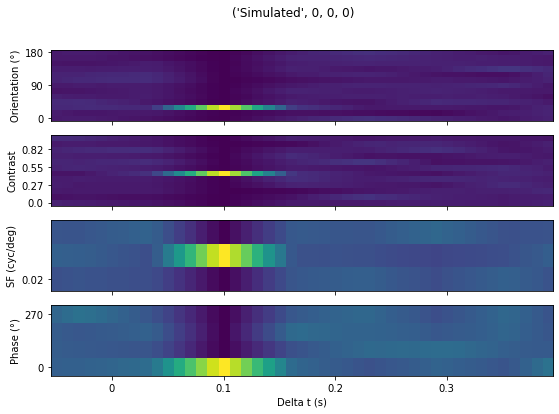

In [64]:
plot(key)